<a href="https://colab.research.google.com/github/dula995/ITS_framework/blob/main/publication_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trend in article volume (stacked area chart)

This notebook reads a **RIS** file (example: `My Library1.ris`) and makes a chart like your image:
a **stacked area chart** by **year** and **publication type**.


In [9]:
from google.colab import files

uploaded = files.upload()  # choose your .ris file
ris_path = list(uploaded.keys())[0]  # take the uploaded file name

print("RIS file:", ris_path)


Saving My Library.ris to My Library.ris
RIS file: My Library.ris


In [10]:
# 2) Imports
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# 3) Read and parse RIS
def parse_ris(file_path: str):
    records = []
    current = {}
    pattern = re.compile(r'^([A-Z0-9]{2})\s+-\s+(.*)$')

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.rstrip('\n')
            m = pattern.match(line)
            if not m:
                continue
            tag, value = m.group(1), m.group(2).strip()

            if tag == 'ER':
                if current:
                    records.append(current)
                current = {}
                continue

            current.setdefault(tag, []).append(value)

    return records

records = parse_ris(ris_path)
len(records)


308

In [12]:
# 4) Make a table (DataFrame) with Year and Publication Type
def pick_year(rec):
    # try PY first, then DA, then Y1
    for tag in ['PY', 'DA', 'Y1']:
        if tag in rec and rec[tag]:
            text = rec[tag][0]
            m = re.search(r'(19\d{2}|20\d{2})', text)
            if m:
                return int(m.group(1))
    return None

type_map = {
    'JOUR': 'Journal Article',
    'JOURNAL': 'Journal Article',
    'CONF': 'Conference Paper',
    'CPAPER': 'Conference Paper',
    'BOOK': 'Book',
    'CHAP': 'Book Section',
    'THES': 'Thesis',
    'RPRT': 'Report',
}

rows = []
for rec in records:
    year = pick_year(rec)
    ty = rec.get('TY', ['GEN'])[0] if rec.get('TY') else 'GEN'
    pub_type = type_map.get(ty, 'Other')
    if year is not None:
        rows.append({'year': year, 'publication_type': pub_type})

df = pd.DataFrame(rows)
df.head()


,year,publication_type
0,2024,Journal Article
1,2021,Journal Article
2,2025,Journal Article
3,2020,Journal Article
4,2021,Journal Article


In [13]:
# 5) Count papers by year and type
counts = (
    df.groupby(['year', 'publication_type'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
counts


publication_type,Conference Paper,Journal Article,Report
year,,,
2017,0,0,2
2020,0,4,5
2021,2,13,2
2022,6,10,2
2023,9,114,6
2024,4,113,6
2025,3,7,0


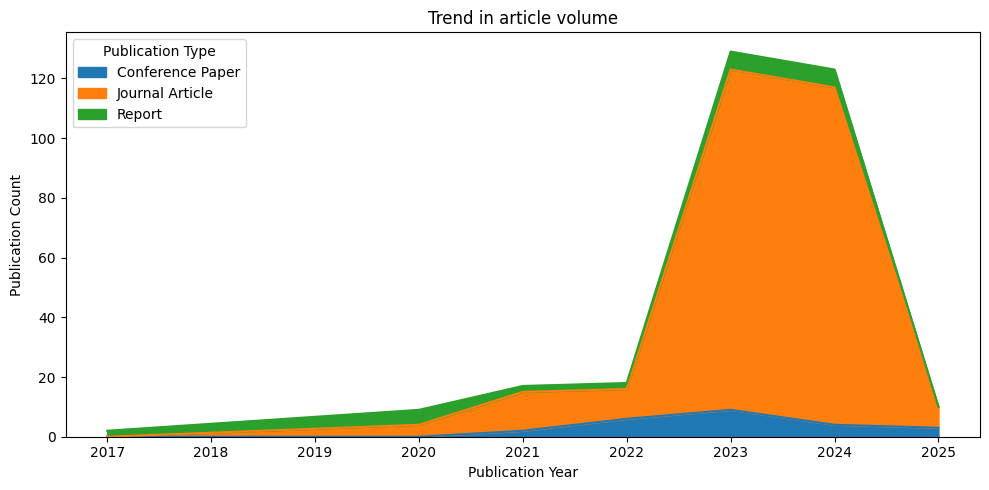

In [14]:
# 6) Plot stacked area chart
ax = counts.plot.area(figsize=(10, 5), stacked=True)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Publication Count')
ax.set_title('Trend in article volume')
ax.legend(title='Publication Type', loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
# 7) Optional: save the chart as an image
out_png = 'publication_trend.png'
fig = ax.get_figure()
fig.savefig(out_png, dpi=300, bbox_inches='tight')
out_png


'publication_trend.png'